## Scattering of unpolarized light by a dielectric ice crystal
An unpolarized wave travelling in the x-direction strikes a dielectric obstacle in fixed orientation. 
We wish tp calculate the scattering matrix elements in the $(x,y)$-plane, and the scattering, extinction and absorption cross sections. See "The boundary element method for light scattering by ice crystals and its implementation in BEM++" (2015) for more details of the setup.

Consider the scattering of a monochromatic plane wave with time-dependence $e^{-\mbox{i}\omega t}$ by an open and bounded set $\Omega_2\subset\mathbb{R}^3$. Suppose that $\Omega_2$ is occupied by a homogeneous and isotropic dielectric material with a complex refractive index $n_2:=\sqrt{\mu_2\varepsilon_2}$. Further it is assumed that $\Omega_2$ is surrounded by an unbounded homogeneous medium $\Omega_1 := \mathbb{R}^3\backslash\overline{\Omega_2}$ with refractive index $n_1:=\sqrt{\mu_1\varepsilon_1}$ where $\overline{\Omega_2}$ denotes the closure of $\Omega_2$ in $\mathbb{R}^3$. Throughout, we shall refer to $\Omega_1$ and $\Omega_2$ as the exterior and interior domains, respectively. Now we state the $\textit{electromagnetic transmission problem}$.

<img src=dielectric.png width="400">

## Electromagnetic transmission problem
Given an incident field $\mathbf{E}^i(\mathbf{x})= \mathbf{E}_0e^{\mbox{i} k_1\mathbf{d}^i\cdot\mathbf{x}}$, where $\mathbf{x}\in\mathbb{R}^3$ and $\mathbf{d}^i$ is a unit direction vector, we wish to determine the fields $\mathbf{E}_1(\mathbf{x})$ and $\mathbf{E}_2(\mathbf{x})$ satisfying

\begin{align}
   \nabla\times\nabla\times\mathbf{E}_1 - k_1^2\mathbf{E}_1 & = 0 \quad \mbox{in}\ \Omega_1, \\ 
   \nabla\times\nabla\times\mathbf{E}_2 - k_2^2\mathbf{E}_2 & = 0 \quad \mbox{in}\ \Omega_2,
\end{align}

and the transmission conditions on the boundary $\Gamma$:

\begin{align}
    \gamma_D^+\mathbf{E}_1 = \gamma_D^-\mathbf{E}_2  \quad \mbox{and} \quad \frac{k_1}{\mu_1}\gamma_N^+\mathbf{E}_1 = \frac{k_2}{\mu_2}\gamma_N^-\mathbf{E}_2 \quad \mbox{on}\ \Gamma,
\end{align}

where $k_j = \omega\sqrt{\mu_j\varepsilon_j}$ for $j=1,2$. In addition, the scattered field $\mathbf{E}^s:=\mathbf{E}_1-\mathbf{E}^i$ must satisfy the Silver-Muller radiation condition

\begin{align}
    \hat{\mathbf{x}}\times\nabla\times\mathbf{E}^s(\mathbf{x})+\mbox{i} k_1\mathbf{E}^s(\mathbf{x}) = o\left(\frac{1}{r}\right)\quad \mbox{as}\quad r:=|\mathbf{x}|\rightarrow\infty,
\end{align}

where $\hat{\mathbf{x}}=\mathbf{x}/|\mathbf{x}|$. The above operators $\gamma_D^+$ and $\gamma_D^-$ denote respectively the exterior and interior Dirichlet trace operators where the Dirichlet trace operator is defined as

\begin{align}
     \gamma_D\mathbf{E} := \mathbf{n}\times \mathbf{E}\vert_{\Gamma},
\end{align}

where $\mathbf{n}$ is the outward normal to $\Gamma$. The operators $\gamma_N^+$ and $\gamma_N^-$ denote respectively the exterior and interior Neumann trace operators where the Neumann trace operator is defined as

\begin{align}
    \gamma_N\mathbf{E} := \frac{1}{\mbox{i} k}\mathbf{n}\times(\nabla\times\mathbf{E})|_{\Gamma}.
\end{align}

In [1]:
import bempp.api
import numpy as np

Currently assembly is performed in `dense` mode since I cannot get iterative solvers to work yet.

In [2]:
kExt = 5.
h = 2*np.pi/(5 * kExt) # 5 to 10 elements per exterior wavelength gives reasonable accuracy

In [3]:
ref_ind = 1.311+2.289e-9j

In [4]:
grid = bempp.api.shapes.sphere(h=h) # creates a sphere

Define the material properties. Introduce $\rho$ as 

$$
    \rho = \frac{k_2 \mu_1}{k_1 \mu_2}.
$$

In [5]:
muInt = 1
muExt = 1
kInt = kExt * ref_ind
rho = (kInt * muExt) / (kExt * muInt)

A suitable space for Maxwell problems is the Raviart-Thomas space of order 0. Higher-order Raviart-Thomas spaces are currently not available in BEM++.

In [6]:
space = bempp.api.function_space(grid, "RT", 0)
print("The space has {0} dofs".format(space.global_dof_count))
curl_space = bempp.api.function_space(grid, "NC", 0)

The space has 969 dofs


To calculate the scattering for an unpolarized incident wave, we consider two different polarizations of the incident wave. These $z$-polarized, i.e.,

$$
    \mathbf{E}_0 = (0,0,1),
$$

and $y$-polarized, i.e.,

$$
    \mathbf{E}_0 = (0,1,0).
$$

For these two incident waves, we define the `incident_field` functions along with functions corresponding to their Dirichlet and Neumann traces.

In [7]:
# Incident field polarized in z-direction
def incident_field_z(x):
    return np.array([0. * x[0], 0. * x[0], np.exp(1j * kExt * x[0])])

# Incident field polarized in y-direction
def incident_field_y(x):
    return np.array([0. * x[0], np.exp(1j * kExt * x[0]), 0. * x[0]])

# Create incident field definition and its Dirichlet and Neumann traces
def evalIncDirichletTrace_z(x, n, domain_index, result):
    result[:] = np.cross(incident_field_z(x), n, axis=0)
    
def evalIncDirichletTrace_y(x, n, domain_index, result):
    result[:] = np.cross(incident_field_y(x), n, axis=0)

def evalIncNeumannTrace_z(x, n, domain_index, result):
    curl = np.array([x[0] * 0. ,-1j * kExt * np.exp(1j * kExt * x[0]), x[0] * 0.])
    result[:] = np.cross(curl / (1j * kExt), n, axis=0)
    
def evalIncNeumannTrace_y(x, n, domain_index, result):
    curl = np.array([x[0] * 0., x[0] * 0. ,1j * kExt * np.exp(1j * kExt * x[0])])
    result[:] = np.cross(curl / (1j * kExt) , n, axis=0)
    
# Construct the grid functions representing the traces of the incident field
incDirichletTrace_z = bempp.api.GridFunction(space, fun=evalIncDirichletTrace_z)
incNeumannTrace_z = bempp.api.GridFunction(space, fun=evalIncNeumannTrace_z)
incDirichletTrace_y = bempp.api.GridFunction(space, fun=evalIncDirichletTrace_y)
incNeumannTrace_y = bempp.api.GridFunction(space, fun=evalIncNeumannTrace_y)

## Boundary integral equation formulation

In [8]:
# Construct necessary BIE operators
slpOpExt = bempp.api.operators.boundary.maxwell.electric_field(space,space,curl_space,kExt)
dlpOpExt = bempp.api.operators.boundary.maxwell.magnetic_field(space,space,curl_space,kExt)
slpOpInt = bempp.api.operators.boundary.maxwell.electric_field(space,space,curl_space,kInt)
dlpOpInt = bempp.api.operators.boundary.maxwell.magnetic_field(space,space,curl_space,kInt)
idOp = bempp.api.operators.boundary.sparse.identity(space,space,curl_space)

This is the integral equation employed in my JQSRT paper, namely:

\begin{equation}
     \begin{pmatrix} \mathcal{C}_+ + \mathcal{C}_- & \mathcal{S}_+ + \frac{1}{\rho}\mathcal{S}_- \\ -\mathcal{S}_+ - \rho \mathcal{S}_- & \mathcal{C}_+ + \mathcal{C}_- \end{pmatrix}
     \begin{pmatrix} \gamma_D\mathbf{E} \\ \gamma_N\mathbf{E} \end{pmatrix}
     =
     \begin{pmatrix} \gamma_D\mathbf{E}^i \\ \gamma_N\mathbf{E}^i \end{pmatrix}.
\end{equation}
   
Later we provide another possible integral equation formulation. The user may experiment with both to decide which is superior. 

Note that here all traces are the positive traces, i.e., those taken from the exterior of the scatterer. 

In [9]:
# # Form the left- and right-hand-side operators
# lhsOp = bempp.api.BlockedOperator(2, 2)
# lhsOp[0,0] = lhsOp[1,1] = dlpOpExt + dlpOpInt
# lhsOp[0,1] = slpOpExt + (1. / rho) * slpOpInt
# lhsOp[1,0] = -(slpOpExt + rho * slpOpInt)

# uI_z = idOp * incDirichletTrace_z
# dudnI_z = idOp * incNeumannTrace_z
# uI_y = idOp * incDirichletTrace_y
# dudnI_y = idOp * incNeumannTrace_y

# rhs_z=2*[None]
# rhs_z[0] = uI_z
# rhs_z[1] = dudnI_z
# rhs_y=2*[None]
# rhs_y[0] = uI_y
# rhs_y[1] = dudnI_y

The integral equation formulation below is that employed in [Timo's Oberwolfach paper (2013)](https://www.mfo.de/document/1304/OWR_2013_03.pdf), namely:

\begin{equation}
     \begin{pmatrix} \mathcal{S}_+ + \mathcal{S}_- & -\left(\frac{1}{2}(1-\frac{1}{\rho})\mathcal{I}+ \mathcal{C}_+ + \frac{1}{\rho}\mathcal{C}_-\right) \\ \frac{1}{2}(1-\rho)\mathcal{I}+\mathcal{C}_+ + \rho\mathcal{C}_- & \mathcal{S}_+ + \mathcal{S}_- \end{pmatrix}
     \begin{pmatrix} \gamma_D\mathbf{E} \\ \gamma_N\mathbf{E} \end{pmatrix}
     =
     \begin{pmatrix} -\gamma_N\mathbf{E}^i \\ \gamma_D\mathbf{E}^i \end{pmatrix}.
   \end{equation}

In [10]:
# Alternative integral equation formulation (from Timo's Oberwolfach paper)
# Form the left- and right-hand-side operators
lhsOp = bempp.api.BlockedOperator(2, 2)
lhsOp[0,0] = lhsOp[1,1] = slpOpExt + slpOpInt
lhsOp[0,1] =  -(dlpOpExt + dlpOpInt * (1. / rho) + 0.5 * (1. - 1. / rho) * idOp)
lhsOp[1,0] =  (dlpOpExt + dlpOpInt * rho + 0.5 * (1. - 1. * rho) * idOp)

uI_z = idOp * incDirichletTrace_z
dudnI_z = -idOp * incNeumannTrace_z
uI_y = idOp * incDirichletTrace_y
dudnI_y = -idOp * incNeumannTrace_y

rhs_z=2*[None]
rhs_z[0] = dudnI_z
rhs_z[1] = uI_z
rhs_y=2*[None]
rhs_y[0] = dudnI_y
rhs_y[1] = uI_y

## Solving the system
We solve the system by converting the blocked integral operator and the right-hand side to numpy arrays and then using the linalg.solve command. This does not exploit $\mathcal{H}$-matrix compression, however it is the only method with which I can obtain the correct solution at present.

In [11]:
lambda_data_z, info, its_z = bempp.api.linalg.gmres(
    lhsOp, rhs_z, tol=1e-05, maxiter=None, return_iteration_count=True)
print("The z-polarized linear system was solved in {0} iterations".format(its_z))

The z-polarized linear system was solved in 192 iterations


In [12]:
lambda_data_y, info, its_y = bempp.api.linalg.gmres(
    lhsOp, rhs_y, tol=1e-05, maxiter=None, return_iteration_count=True)
print("The y-polarized linear system was solved in {0} iterations".format(its_y))

The y-polarized linear system was solved in 195 iterations


Extract $\gamma_D\mathbf{E}$ and $\gamma_N\mathbf{E}$ and store as BEM++ grid functions.

In [13]:
# Gather the appropriate parts of the solution.
total_field_dirichlet_z = lambda_data_z[0]
total_field_neumann_z = lambda_data_z[1]

total_field_dirichlet_y = lambda_data_y[0]
total_field_neumann_y = lambda_data_y[1]

## Calculate far-field and scattering matrix from boundary data
We calculate the far-field pattern in 3601 evenly spaced directions in the $(x,y)$-plane.

In [14]:
bempp.api.global_parameters.hmat.eps = 1E-5
theta = np.linspace(0, 2 * np.pi, 3601)
points = np.vstack([np.cos(theta), np.sin(theta), 0. * theta])

In [15]:
dlp_far_field = bempp.api.operators.far_field.maxwell.magnetic_field(space, points, kExt)
slp_far_field = bempp.api.operators.far_field.maxwell.electric_field(space, points, kExt)

ffp_z = -dlp_far_field.evaluate(total_field_dirichlet_z) -slp_far_field.evaluate(total_field_neumann_z)
ffp_y = -dlp_far_field.evaluate(total_field_dirichlet_y) -slp_far_field.evaluate(total_field_neumann_y)

From the far-field, the $\textit{amplitude scattering matrix}$ entries are calculated.

In [16]:
A22 = -1j * kExt * ffp_z[2,:]   # -1j * kExt is to make agree with eqn 3.21 p70 Bohren and Huffman
A12 = -1j * kExt * (- np.sin(theta) * ffp_z[0,:] + np.cos(theta) * ffp_z[1,:])

A11 = -1j * kExt * (- np.sin(theta) * ffp_y[0,:] + np.cos(theta) * ffp_y[1,:])
A21 = -1j * kExt * ffp_y[2,:]

The amplitude scattering matrix is then used to calculated the $\textit{phase scattering matrix}$.

In [17]:
S11 = 0.5*(abs(A11)**2+abs(A22)**2+abs(A21)**2+abs(A12)**2)
S12 = 0.5*(abs(A11)**2-abs(A22)**2+abs(A21)**2-abs(A12)**2)
S13 = np.real(A11*np.conjugate(A12)+A22*np.conjugate(A21))
S14 = np.imag(A11*np.conjugate(A12)-A22*np.conjugate(A21))
S21 = 0.5*(abs(A11)**2-abs(A22)**2-abs(A21)**2+abs(A12)**2)
S22 = 0.5*(abs(A11)**2+abs(A22)**2-abs(A21)**2-abs(A12)**2)
S23 = np.real(A11*np.conjugate(A12)-A22*np.conjugate(A21))
S24 = np.imag(A11*np.conjugate(A12)+A22*np.conjugate(A21))
S31 = np.real(A11*np.conjugate(A21)+A22*np.conjugate(A12))
S32 = np.real(A11*np.conjugate(A21)-A22*np.conjugate(A12))
S33 = np.real(np.conjugate(A11)*A22+A12*np.conjugate(A21))
S34 = np.imag(A11*np.conjugate(A22)+A21*np.conjugate(A12))
S41 = np.imag(np.conjugate(A11)*A21+np.conjugate(A12)*A22)
S42 = np.imag(np.conjugate(A11)*A21-np.conjugate(A12)*A22)
S43 = np.imag(A22*np.conjugate(A11)-A12*np.conjugate(A21))
S44 = np.real(np.conjugate(A11)*A22-A12*np.conjugate(A21))

## Comparison to exact solution from Mie theory
If we are considering scattering by a sphere, we can compare the BEM approximation to the analytical solution obtained via Mie theory (separation of variables (give reference)).

In [18]:
from mie_series import bhmie
ka = kExt
refIndex = ref_ind
numAngles = 901

[s1,s2,qext,qsca,qback,gsca]=bhmie(ka,refIndex,numAngles)
P11Mie = 0.5*(abs(s1)**2+abs(s2)**2)#*4*pi/(ka**2*pi*qsca)

Plot entries of the amplitude scattering matrix. For the sphere, $A_{12}=A_{21}=0$.

[None, None, None, None, None, None, None, None]

/usr/lib/python2.7/dist-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


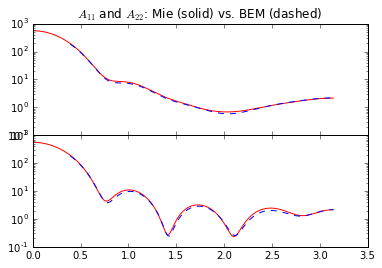

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import pylab

f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True)
ax1.semilogy(theta[:1801],abs(s2)**2,'-r',theta[:1801],abs(A11[:1801])**2,'--b')
ax1.set_title('$A_{11}$ and $A_{22}$: Mie (solid) vs. BEM (dashed)')
ax2.semilogy(theta[:1801],abs(s1)**2,'-r',theta[:1801],abs(A22[:1801])**2,'--b')
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)


Written by S. P. Groth on 5th November 2016, Reading, UK.